In [32]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [33]:
import tiktoken
tokenizer = tiktoken.encoding_for_model("gpt-4")

In [52]:
with open('/home/zinccat/datasets/data/data/toolllama_G123_dfs_eval.json', 'r') as file:
    data = json.load(file)

In [53]:
data = pd.DataFrame(data)
data.head()

,id,conversations
0,Step 9: I'm a sports enthusiast and I'm intere...,"[{'from': 'system', 'value': 'You are AutoGPT,..."
1,Step 9: I am a music enthusiast and I need hel...,"[{'from': 'system', 'value': 'You are AutoGPT,..."
2,"Step 8: As a trader, I want to evaluate the pe...","[{'from': 'system', 'value': 'You are AutoGPT,..."
3,Step 8: My company is developing a trading pla...,"[{'from': 'system', 'value': 'You are AutoGPT,..."
4,Step 5: I want to surprise my sister with a un...,"[{'from': 'system', 'value': 'You are AutoGPT,..."


In [54]:
data.iloc[0]['conversations']

[{'from': 'system',
  'value': 'You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step. Your output should follow this format:\nThought:\nAction\nAction Input:\n\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can\'t go back to one of the former state, if you want to restart the task, say "I give up and restart".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet\'s Begin!\n

In [55]:
length = []
length_total = []
turns = []
for conv in data['conversations']:
    cnt = 0
    len_cnt = 0
    len_api = 0
    len_sys = 0
    for turn in conv:
        if turn['from'] == 'system':
            len_sys += len(tokenizer.encode(turn['value']))
        if turn['from'] == 'assistant':
            # length.append(len(tokenizer.encode(turn['value'])))
            len_cnt += len(tokenizer.encode(turn['value']))
            cnt += 1
        if turn['from'] == 'function':
            len_api += len(tokenizer.encode(turn['value']))
            cnt += 1
    turns.append(cnt)
    length.append(len_cnt)
    length_total.append(len_sys+len_cnt + len_api)
# print('Average length: ', np.mean(length))
# print('Average turns: ', np.mean(turns))

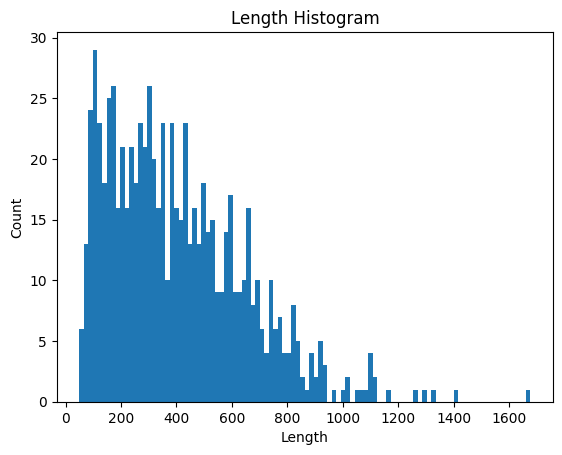

In [7]:
# plot length histogram
plt.hist(length, bins=100)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Length Histogram')
plt.show()

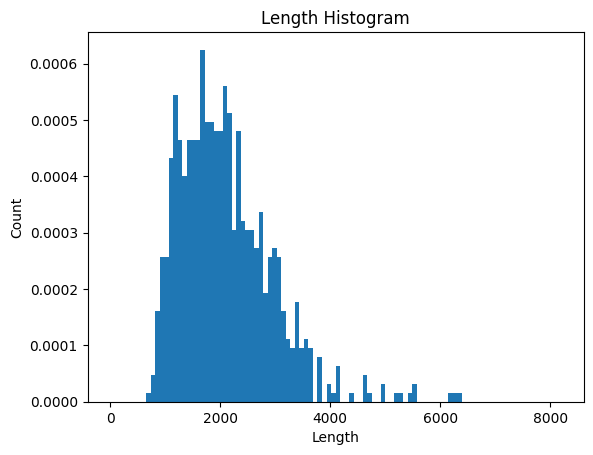

In [57]:
# plot length histogram, y as frequency
# RuntimeWarning: invalid value encountered in divide return n/db/n.sum(), bin_edges
plt.hist(length_total, bins=100, density=True, range=(0, 8192))
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Length Histogram')
plt.show()

(-746.1156993113416, 493516.51999631705, 402.6286134713537, 246.7352514057693)
402.62860892388454 246.73524946490946


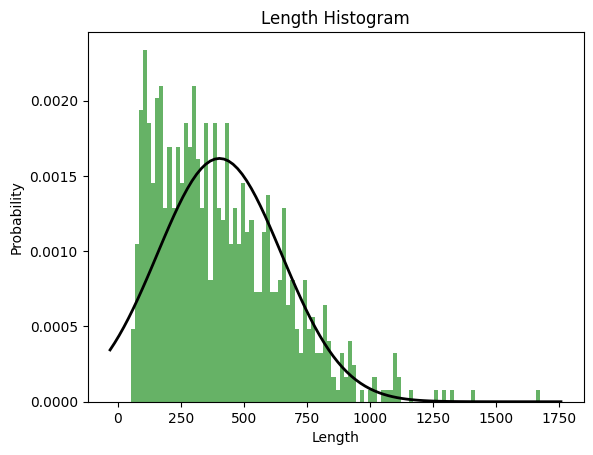

In [10]:
# fit a truncated normal distribution to the length data
from scipy.stats import truncnorm
from scipy.stats import norm

# fit a normal distribution to the data
mu, std = truncnorm.fit(length)
print(mu, std)

# plot the histogram
plt.hist(length, bins=100, density=True, alpha=0.6, color='g')

# plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Length')
plt.ylabel('Probability')
plt.title('Length Histogram')
plt.show()

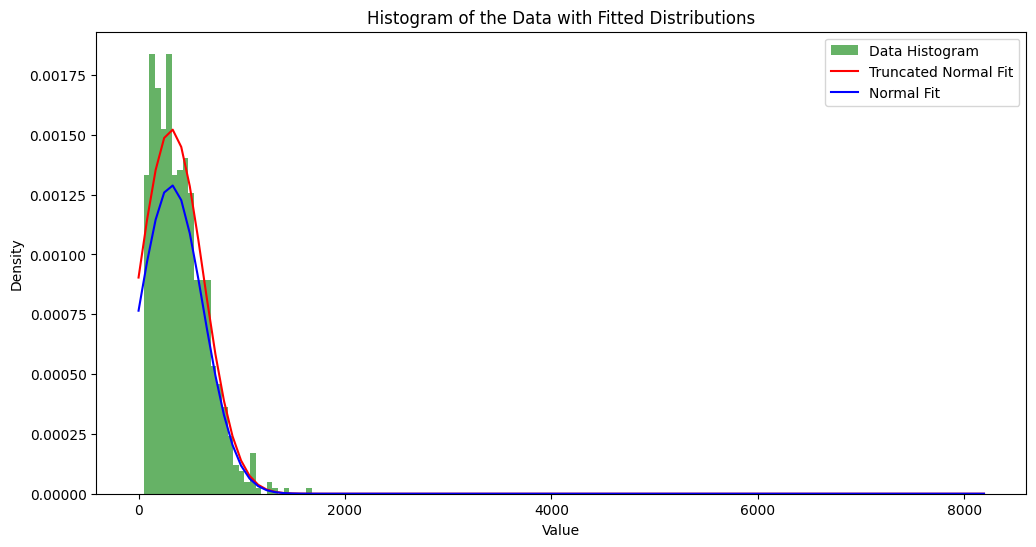

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, norm
from scipy.optimize import minimize

# Example dataset of numbers
data = length

# Estimate parameters for the truncated normal distribution
def negative_log_likelihood(params):
    """ Negative log likelihood function for the truncated normal distribution. """
    loc, scale = params
    ll = -np.sum(np.log(truncnorm.pdf(data, a=(0 - loc) / scale, b=(8192 - loc) / scale, loc=loc, scale=scale)))
    return ll if np.isfinite(ll) else np.inf

# Initial parameter guesses
initial_params = [np.mean(data), np.std(data)]

# Minimize the negative log likelihood
result = minimize(negative_log_likelihood, initial_params, bounds=[(0, None), (0, None)])
estimated_mean, estimated_std = result.x

# Create a range of values for plotting
x = np.linspace(0, 8192, 100)

# Plot the histograms and fitted distributions
plt.figure(figsize=(12, 6))

# Histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

# Plot the estimated truncated normal distribution
plt.plot(x, truncnorm.pdf(x, a=(0 - estimated_mean) / estimated_std, b=(8192 - estimated_mean) / estimated_std, loc=estimated_mean, scale=estimated_std), 'r-', label='Truncated Normal Fit')

# Plot the estimated normal distribution
plt.plot(x, norm.pdf(x, loc=estimated_mean, scale=estimated_std), 'b-', label='Normal Fit')

plt.title('Histogram of the Data with Fitted Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


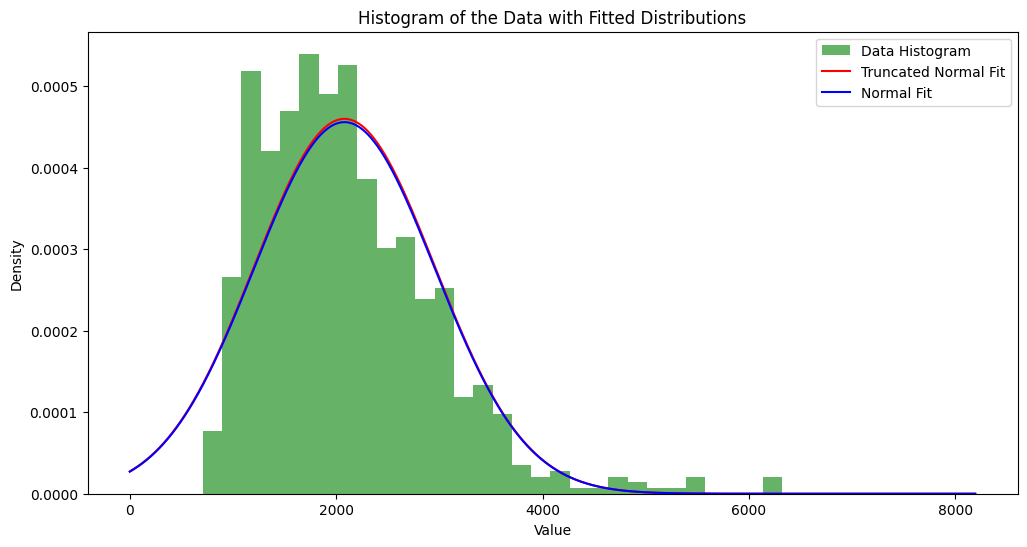

In [58]:
# full length
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, norm
from scipy.optimize import minimize

# Example dataset of numbers
data = length_total

# Estimate parameters for the truncated normal distribution
def negative_log_likelihood(params):
    """ Negative log likelihood function for the truncated normal distribution. """
    loc, scale = params
    ll = -np.sum(np.log(truncnorm.pdf(data, a=(0 - loc) / scale, b=(8192 - loc) / scale, loc=loc, scale=scale)))
    return ll if np.isfinite(ll) else np.inf

# Initial parameter guesses
initial_params = [np.mean(data), np.std(data)]

# Minimize the negative log likelihood
result = minimize(negative_log_likelihood, initial_params, bounds=[(0, None), (0, None)])
estimated_mean, estimated_std = result.x

# Create a range of values for plotting
x = np.linspace(0, 8192, 1000)

# Plot the histograms and fitted distributions
plt.figure(figsize=(12, 6))

# Histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

# Plot the estimated truncated normal distribution
plt.plot(x, truncnorm.pdf(x, a=(0 - estimated_mean) / estimated_std, b=(8192 - estimated_mean) / estimated_std, loc=estimated_mean, scale=estimated_std), 'r-', label='Truncated Normal Fit')

# Plot the estimated normal distribution
plt.plot(x, norm.pdf(x, loc=estimated_mean, scale=estimated_std), 'b-', label='Normal Fit')

plt.title('Histogram of the Data with Fitted Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


2079.569102180148 875.2616808056199


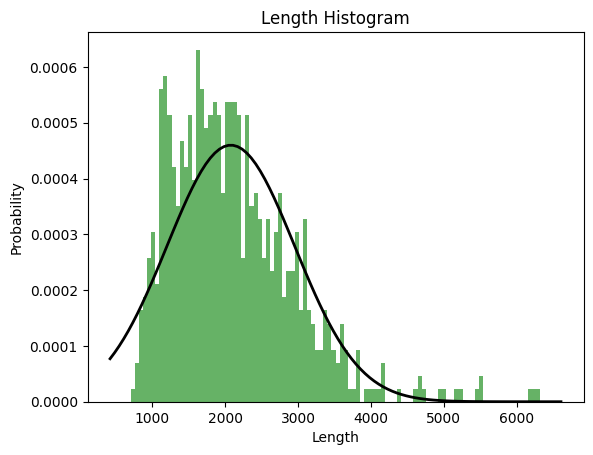

In [60]:
# fit a truncated normal distribution to the length data
from scipy.stats import truncnorm
from scipy.stats import norm

# fit a normal distribution to the data
print(estimated_mean, estimated_std)

# plot the histogram
plt.hist(length_total, bins=100, density=True, alpha=0.6, color='g')

# plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = truncnorm.pdf(x, a=(0 - estimated_mean) / estimated_std, b=(8192 - estimated_mean) / estimated_std, loc=estimated_mean, scale=estimated_std)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Length')
plt.ylabel('Probability')
plt.title('Length Histogram')
plt.show()

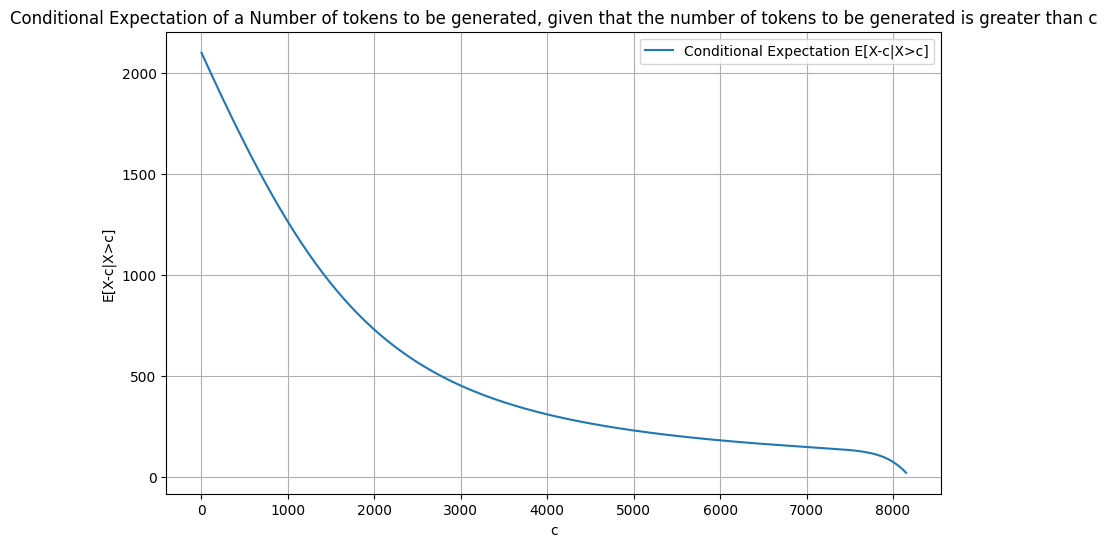

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# Define the parameters for the truncated normal distribution
lower_bound = 0
upper_bound = 8192
mean, std = estimated_mean, estimated_std

# Define the function to calculate the conditional expectation
def conditional_expectation(c, lower_bound, upper_bound, mean, std):
    if c < lower_bound or c > upper_bound:
        raise ValueError("c must be within the bounds of the distribution")

    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    c_scaled = (c - mean) / std

    # Calculate the conditional expectation
    numerator = truncnorm(a, b, loc=mean, scale=std).expect(lambda x: x, lb=c, ub=upper_bound)
    denominator = truncnorm(a, b, loc=mean, scale=std).cdf(upper_bound) - truncnorm(a, b, loc=mean, scale=std).cdf(c)

    if denominator == 0:
        return np.nan  # Avoid division by zero
    else:
        return numerator / denominator

# Generate values for c and corresponding conditional expectations
c_values = np.linspace(lower_bound, upper_bound, 200)
expectations = [(conditional_expectation(c, lower_bound, upper_bound, mean, std) - c) for c in c_values]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(c_values, expectations, label='Conditional Expectation E[X-c|X>c]')
plt.xlabel('c')
plt.ylabel('E[X-c|X>c]')
plt.title('Conditional Expectation of a Number of tokens to be generated, given that the number of tokens to be generated is greater than c')
plt.legend()
plt.grid(True)
plt.show()


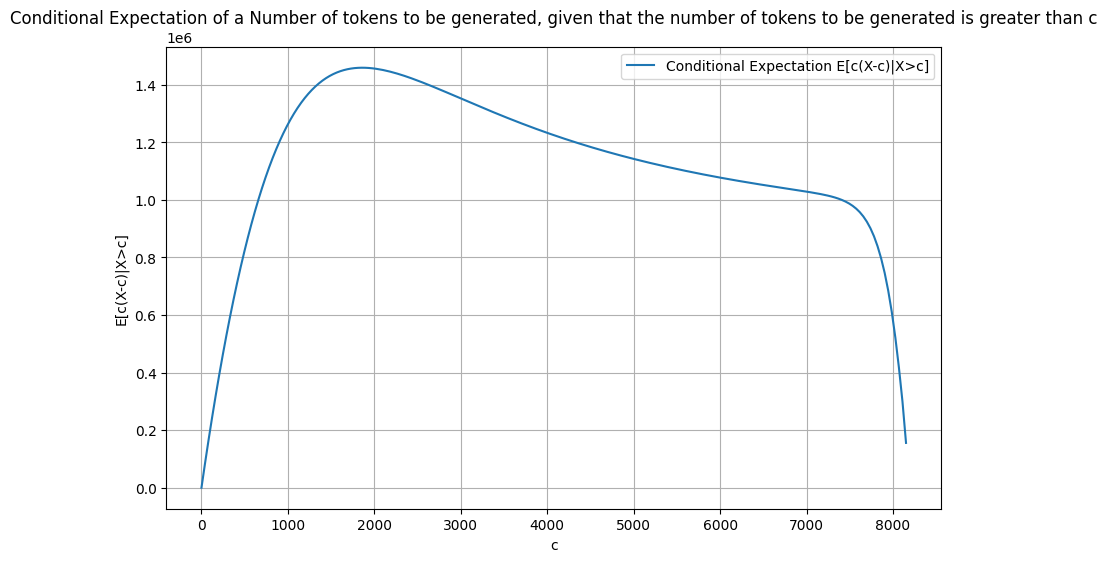

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# Define the parameters for the truncated normal distribution
lower_bound = 0
upper_bound = 8192
mean, std = estimated_mean, estimated_std

# Define the function to calculate the conditional expectation
def conditional_expectation(c, lower_bound, upper_bound, mean, std):
    if c < lower_bound or c > upper_bound:
        raise ValueError("c must be within the bounds of the distribution")

    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    c_scaled = (c - mean) / std

    # Calculate the conditional expectation
    numerator = truncnorm(a, b, loc=mean, scale=std).expect(lambda x: x, lb=c, ub=upper_bound)
    denominator = truncnorm(a, b, loc=mean, scale=std).cdf(upper_bound) - truncnorm(a, b, loc=mean, scale=std).cdf(c)

    if denominator == 0:
        return np.nan  # Avoid division by zero
    else:
        return numerator / denominator

# Generate values for c and corresponding conditional expectations
c_values = np.linspace(lower_bound, upper_bound, 200)
expectations = [c*(conditional_expectation(c, lower_bound, upper_bound, mean, std) - c) for c in c_values]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(c_values, expectations, label='Conditional Expectation E[c(X-c)|X>c]')
plt.xlabel('c')
plt.ylabel('E[c(X-c)|X>c]')
plt.title('Conditional Expectation of a Number of tokens to be generated, given that the number of tokens to be generated is greater than c')
plt.legend()
plt.grid(True)
plt.show()


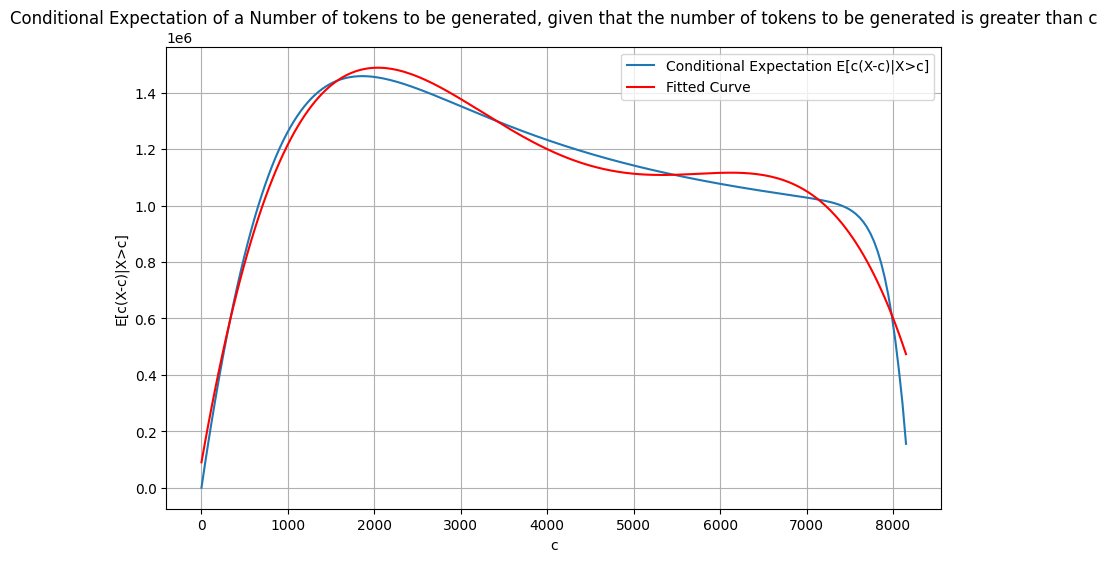

In [80]:
# fit a polynomial to the expectation data
from scipy.optimize import curve_fit

# Define the function to fit
def func(x, a, b, c, d, e):
    return a + b*x + c*x**2 + d*x**3 + e*x**4

# Fit the function
popt, pcov = curve_fit(func, c_values, expectations)

# Plot the results

plt.figure(figsize=(10, 6))
plt.plot(c_values, expectations, label='Conditional Expectation E[c(X-c)|X>c]')
plt.plot(c_values, func(c_values, *popt), 'r-', label='Fitted Curve')
plt.xlabel('c')
plt.ylabel('E[c(X-c)|X>c]')
plt.title('Conditional Expectation of a Number of tokens to be generated, given that the number of tokens to be generated is greater than c')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
c_values = c_values[:-1]

In [71]:
c_values.shape

(200,)